# Things on the to do list
- Add mlflow for experiment tracking
- Add NN recall metric: 
    - if we keep the closest N merchants to a transaction, is the correct merchant in the top N. 
    - Get metrics of NN_recall for different values of N. 
- Test and compare the performance of different loss functions, with everything7 else the same (batch size, lr, etc)
- With one model, test and compare the performance with different batch sizes
- Test and compare the performance when the text column is not only the transaction description, but also the transaction description and amount, i,e + 'Amount' :  amount
- Any other feature engineering that we can think of: adding avg number of transactions per month for that merchant, location of transaction (if available, etc)
- Find the best models.  We are looking for two best models
    - Model 1: The model with the highest precision. 
    - Model 2: The model with the best NN_recall
- Compare with performance of finetuned model "s3://cleo-data-science/income-transaction-classifier/models/v3_mlflow_run_id_95a2f1ee97954bc58c16cc68501b55de_checkpoint-40000_ft.tar.gz" which has a type1 loss
- loss type = 4 is not working yet, I can  look into this
- code refactoring. Create a class and methods with all the functions here


https://sbert.net/docs/sentence_transformer/training_overview.html#dataset-format

In [1]:
import numpy as np
import torch
print(torch.__version__)
print(torch.cuda.is_available())
%pip install accelerate -U

import accelerate
print(accelerate.__version__)
#%pip install accelerate

#%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install umap-learn
#%pip install cleodata --extra-index-url "https://aws:$(aws codeartifact get-authorization-token --domain meetcleo --domain-owner 878877078763 --query authorizationToken --output text)@meetcleo-878877078763.d.codeartifact.us-east-1.amazonaws.com/pypi/meetcleo-releases/simple/"
%pip install awswrangler
# %pip install --upgrade sentence_transformers

2.0.0.post200
True
Note: you may need to restart the kernel to use updated packages.
0.33.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datetime import datetime
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
from io import StringIO
#from fastparquet import ParquetFile
#boto3.setup_default_session(profile_name='DataScientist-878877078763')
# from cleodata.utils.secrets import get_secret
#from cleodata.sources.sync.sync import SyncDataSource
#redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [3]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='/home/sagemaker-user/logging/biencoder.log',  # Log messages to a file
                    filemode='w')  # Overwrite the log file on each run

In [4]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import umap

2024-07-26 11:09:31.045761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from sentence_transformers import SentenceTransformer, models, InputExample

In [6]:

from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.model_selection import train_test_split

In [7]:
import sentence_transformers
print(sentence_transformers.__version__)
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sentence_transformers import losses
from datasets import Dataset



3.0.1


# Data Loading

In [8]:
debug = 1

In [9]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "https://cleo-data-science.s3.amazonaws.com/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-18_2024-05-18_top_1_39000.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
#s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/data_tmp_trans_23_06_24_06_pairs/tmp_trans_23_06_24_06_pairs"

df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

if debug: df_data_raw = df_data_raw.sample(50000, random_state= 1)
print(df_data_raw.shape)
logging.info(df_data_raw.shape)

(50000, 11)


In [10]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
4241978,9994008807,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,O''Reilly Auto Parts,0,O''Reilly Auto Parts,-48.4,Nando''s PERi-PERi,0,0.169511
7755514,9816935543,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee,0,ATM Fee,-1.0,ATM Fee,1,0.885608
3054820,9817615044,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave Inc,0,Dave Inc,-1.0,Red Rover,0,0.184990
8753082,9834581115,SHELL OIL ORLANDO FL 05/15. Channel: in store....,SHELL OIL ORLANDO FL 05/15. Type: merchant. Ch...,SHELL OIL ORLANDO FL 05/15,Shell,0,Shell,-5.4,Chillbox,0,0.101866
1764279,9807730741,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,Sunoco,0,Sunoco,-24.0,Sunoco,1,0.737140


In [11]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.1, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

42750 4750 2500


In [12]:
text_col = "description_combined_processed"
df_train['len_sentence'] = df_train[text_col].apply(lambda x: len(x.split(' ')))
print(df_train['len_sentence'].max())

34


In [13]:
one_sent = df_train[text_col][0]
print(df_train[text_col][1])
df_train['label'] = df_train['label'].astype('float32')
df_train['true_label'] = df_train['true_label'].astype('float32')
#train_examples = [InputExample(texts = [df_train.loc[i,'sentence'], df_train.loc[i,'merchant_name_combined']], label=df_train.loc[i,'true_label']  ) for i in range(df_train.shape[0])]
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)


POS Debit - Visa Check Card - BP M L K ATLANTA CYNTHIA WINZER POS TRANSACTION


# Create Dataset

In [ ]:
def create_cosentloss_dataset(df, text_col_sentence1, text_col_sentence2, label_col_name):
    ds = Dataset.from_pandas(df[[label_col_name,text_col_sentence1,text_col_sentence2]])
    ds = ds.rename_columns({label_col_name: "score",text_col_sentence1:"sentence1", text_col_sentence2:"sentence2"})
    return ds


def create_contrastiveloss_dataset(df, text_col_sentence1, text_col_sentence2, label_col_name):
    ds = Dataset.from_pandas(df[[label_col_name,text_col_sentence1,text_col_sentence2]])
    ds = ds.rename_columns({label_col_name: "label",text_col_sentence1:"sentence1", text_col_sentence2:"sentence2"})
    return ds



def create_tripletloss_dataset(df,text_col_anchor, text_col_positive, text_col_negative, label_col_name ):
    # we need data in the form anchor, positive, negative
    # Step 1: create dfp has only true matches trx_id, description, merchant, label =1 
    # Step 2: dfn has only negatives. trx_id, description, merchant, label = 0 
    # Step 3: dfp.join(dfn on trx_id), mechant_x = 'positive' , merchant_y = 'negative'

    df_p = df[(df[label_col_name]==1) & (df['is_duplicate']==0)][:]
    df_n = df[(df[label_col_name]==0)  & (df['is_duplicate']==0) ][:]
    df_p = df_p[[text_col_anchor,text_col_positive,label_col_name]][:]
    df_n = df_n[[text_col_anchor,text_col_positive,text_col_negative,label_col_name]][:]
    df_n.drop(text_col_anchor, axis=1, inplace=True)
    df_positive_negative = pd.merge(df_p, df_n, left_on=text_col_positive, right_on=text_col_positive, how='inner')
    #assert df_positive_negative[df_positive_negative[text_col_positive] ==  df_positive_negative[text_col_negative] ].shape[0] ==0 
    df_positive_negative = df_positive_negative[df_positive_negative[text_col_positive] !=  df_positive_negative[text_col_negative] ][:]
    assert df_positive_negative[df_positive_negative[text_col_positive] ==  df_positive_negative[text_col_negative] ].shape[0] ==0 
    df_positive_negative = df_positive_negative[[text_col_anchor,text_col_positive,text_col_negative]][:]
    ds_triplet = Dataset.from_pandas(df_positive_negative)
    ds_triplet = ds_triplet.rename_columns({text_col_anchor: "anchor",text_col_positive:"positive", text_col_negative:"negative"})

    return ds_triplet

In [82]:
type_of_loss = 3

In [83]:
text_col_sentence1 = text_col
text_col_sentence2 = 'merchant_name_combined'
label_col_name = 'true_label'

text_col_anchor = 'description_combined_processed'
text_col_positive = 'original_merchant_name_combined'
text_col_negative = 'merchant_name_combined'

print(type_of_loss)

if type_of_loss == 1:
    # requires columns sentence1, sentence2, score
    ds_train = create_cosentloss_dataset(df_train, text_col_sentence1, text_col_sentence2, label_col_name)
    ds_val = create_cosentloss_dataset(df_val, text_col_sentence1, text_col_sentence2, label_col_name)
    ds_test = create_cosentloss_dataset(df_test, text_col_sentence1, text_col_sentence2, label_col_name)
elif type_of_loss in [2,3]:
    # requires columns sentence1, sentence2, score
    ds_train = create_contrastiveloss_dataset(df_train, text_col_sentence1, text_col_sentence2, label_col_name)
    ds_val = create_contrastiveloss_dataset(df_val, text_col_sentence1, text_col_sentence2, label_col_name)
    ds_test = create_contrastiveloss_dataset(df_test, text_col_sentence1, text_col_sentence2, label_col_name)
elif type_of_loss == 4:
    ds_train = create_tripletloss_dataset(df_train, text_col_anchor, text_col_positive, text_col_negative, label_col_name)
    ds_val = create_tripletloss_dataset(df_val, text_col_anchor, text_col_positive, text_col_negative, label_col_name)
    ds_test = create_tripletloss_dataset(df_test, text_col_anchor, text_col_positive, text_col_negative, label_col_name) 
print(ds_train[0])

3
{'label': 1.0, 'sentence1': 'POS PUR- 05/18 / 15:51 AANI DIAMOND INC LAREDO TX', 'sentence2': 'Aani Diamond I'}


# Model 

In [71]:
import os
directory = "/home/sagemaker-user/logs"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory already exists!


In [84]:

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
print(type_of_loss)
# The type of loss will determine what columns are needed
if type_of_loss == 1:
    train_loss = losses.CoSENTLoss(model)
    # requires columns sentence1, sentence2, score
elif type_of_loss == 2:
    train_loss = losses.ContrastiveLoss(model)
    # requires columns sentence1, sentence2, label
elif type_of_loss == 3:
    train_loss = losses.OnlineContrastiveLoss(model)
    # requires columns sentence1, sentence2, label    
elif type_of_loss == 4:
    # This loss is not working
    train_loss = losses.TripletLoss(model=model)
    #requires columns ancho, positive, negative


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

3


In [73]:
print(torch.cuda.device_count())

1


In [74]:
imodel=12

In [85]:


args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=f"/home/sagemaker-user/models/model{imodel}",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    evaluation_strategy="steps", #eval_strategy
    eval_steps=5,
    save_strategy="steps",
    save_steps=20,
    save_total_limit=10,
    logging_steps=5,
    run_name="test1",  # Will be used in W&B if `wandb` is installed
    load_best_model_at_end= True,
    logging_dir="/home/sagemaker-user/logs",
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [86]:
#pd.set_option('display.float_format', lambda x: '%.f' % x)
#estimate maximum tokenized length
df_train['len_sentence'].describe()

count    42750.000000
mean         8.230760
std          3.908916
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         34.000000
Name: len_sentence, dtype: float64

In [77]:
print(model.max_seq_length)
model.max_seq_length = 128
print(model.max_seq_length)

128
128


In [78]:
#evaluation functions - this all has to be added as methods in a class later
def get_merchant_embeddings(df_train, model):
    list_unique_merchants = df_train['original_merchant_name_combined'].tolist()
    embeddings_merchants = model.encode(list_unique_merchants)
    print(f"Unique merchants {embeddings_merchants.shape[0]}")
    return embeddings_merchants


def predict_merchant(df_test, embeddings_merchants, pred_merchant_col_name):

    #initalize predictions to none
    df_test[pred_merchant_col_name] = None
    df_test['pred_prob'] = 0.0
    batch_size = 1000

    for istart in np.arange(0, df_test.shape[0]+1, batch_size):
        iend = min(df_test.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df_test.loc[istart:iend-1,pred_merchant_col_name] =  predicted_merchant
            df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df_test




def get_accuracy_precision_recall(df_test, th, true_merchant_col_name, pred_merchant_col_name):
    false_positives = df_test[(df_test['pred_prob']>=th) & (df_test[pred_merchant_col_name]!= df_test[true_merchant_col_name])].shape[0]
    true_positives = df_test[(df_test['pred_prob']>=th) & (df_test[pred_merchant_col_name]== df_test[true_merchant_col_name])].shape[0]
    false_negatives = df_test[(df_test['pred_prob']>=th) & (df_test[pred_merchant_col_name]!= df_test[true_merchant_col_name])].shape[0]

    if true_positives+false_positives <0.5:
        precision_th = 0 
    else:
        precision_th = true_positives/(true_positives+false_positives)
    recall_th = true_positives/df_test.shape[0]
    accuracy_th = true_positives/df_test.shape[0]
    print(f"precision {precision_th:.2f} recall {recall_th} accuracy {accuracy_th:.2f}")
    return (precision_th, recall_th, accuracy_th)

### Evaluate precision and recall before finetuning

In [79]:
true_merchant_col_name = 'original_merchant_name_combined'
pred_merchant_col_name = 'pred_merchant'
th = 0.9

embeddings_merchants = get_merchant_embeddings(df_train, model)
df_test = predict_merchant(df_test, embeddings_merchants, pred_merchant_col_name)
get_accuracy_precision_recall(df_test, th, true_merchant_col_name, pred_merchant_col_name)

Batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Unique merchants 42750
0 1000


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([1000, 42750])
1000 2000


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([1000, 42750])
2000 2500


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([500, 42750])
precision 0.00 recall 0.0 accuracy 0.00


(0, 0.0, 0.0)

# Fine tune

In [87]:
# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    loss=train_loss,
    #evaluator=dev_evaluator,
)
trainer.train()

#trainer.train(resume_from_checkpoint="/home/sagemaker-user/models/model9/checkpoint-5000")

#model.save_pretrained(f"/home/sagemaker-user/models/model{imodel}final")

Step,Training Loss,Validation Loss
5,14.003000,6.282969
10,12.237200,4.622763
15,8.073900,3.396667
20,6.447300,3.267466
25,5.251900,2.071696
30,3.905300,1.261997
35,2.827000,0.751489
40,1.584800,0.625417
45,1.700500,0.494108
50,1.233000,0.408022


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=334, training_loss=1.2796013003694797, metrics={'train_runtime': 394.0582, 'train_samples_per_second': 108.487, 'train_steps_per_second': 0.848, 'total_flos': 0.0, 'train_loss': 1.2796013003694797, 'epoch': 1.0})

# Evaluate

In [65]:
th = 0.9

embeddings_merchants = get_merchant_embeddings(df_train, model)
df_test = predict_merchant(df_test, embeddings_merchants, pred_merchant_col_name)
get_accuracy_precision_recall(df_test, th, true_merchant_col_name, pred_merchant_col_name)

Batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Unique merchants 42750
0 1000


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([1000, 42750])
1000 2000


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([1000, 42750])
2000 2500


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([500, 42750])
precision 0.74 recall 0.6652 accuracy 0.67


(0.7404274265360641, 0.6652, 0.6652)

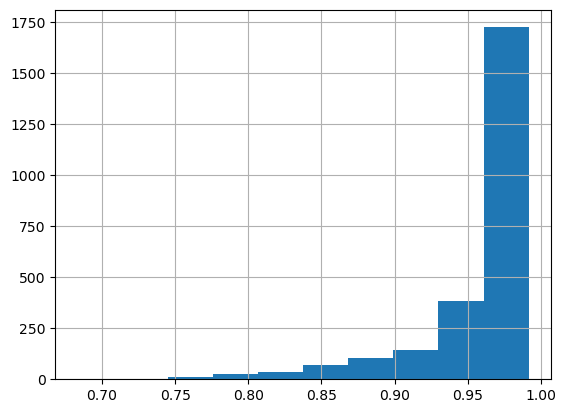

In [66]:
df_test['pred_prob'].hist();

# Upload model to s3

In [ ]:
#copy 
import os
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

def upload_directory_to_s3(local_directory, bucket_name, s3_directory):
    s3_client = boto3.client('s3')

    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_directory, relative_path)

            try:
                s3_client.upload_file(local_path, bucket_name, s3_path)
                print(f'Successfully uploaded {local_path} to s3://{bucket_name}/{s3_path}')
            except FileNotFoundError:
                print(f'The file {local_path} was not found')
            except NoCredentialsError:
                print('Credentials not available')
            except PartialCredentialsError:
                print('Incomplete credentials provided')

# Example usage
local_directory = f"/home/sagemaker-user/models/model{imodel}""
bucket_name = 'cleo-data-science'
s3_directory = f"transaction_enrichment/experimental_data/caste/pairs_model/model{imodel}"

upload_directory_to_s3(local_directory, bucket_name, s3_directory)


Successfully uploaded ./models/model1/checkpoint-600/config_sentence_transformers.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config_sentence_transformers.json
Successfully uploaded ./models/model1/checkpoint-600/config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config.json
Successfully uploaded ./models/model1/checkpoint-600/model.safetensors to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/model.safetensors
Successfully uploaded ./models/model1/checkpoint-600/tokenizer_config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/tokenizer_config.json
Successfully uploaded ./models/model1/checkpoint-600/special_tokens_map.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/special_t

In [67]:
df_no_match = df_test[df_test[pred_merchant_col_name] != df_test[true_merchant_col_name]]
df_no_match.reset_index(drop=True, inplace=True)
df_no_match

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9808298870,Pos Debit- Chumba Gold Coins Valetta. Channel:...,Pos Debit- Chumba Gold Coins Valetta. Type: me...,Pos Debit- Chumba Gold Coins Valetta,Chumba Gold Coins,0,Chumba Gold Coins,-20.0,Chumba Gold Coins,1,0.648948,Chumba Gold Coin Valetta Wpgtid,0.983692
1,9808656262,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,Amazon Prime,0,Amazon Prime,-10.8,Amazon Prime,1,0.933748,Amazon Prime Now,0.975546
2,9819802093,CLEO SALARY ADVANCE WILMINGTON DE 05/16. Chann...,CLEO SALARY ADVANCE WILMINGTON DE 05/16. Type:...,CLEO SALARY ADVANCE WILMINGTON DE 05/16,Cleo,0,Cleo,70.0,Cleo,1,0.894569,Cleo AI,0.976441
3,9820073067,KING WOK SUMTER SC. Channel: in store. Amount:...,KING WOK SUMTER SC. Type: merchant. Channel: i...,KING WOK SUMTER SC,King Wok,0,King Wok,-46.4,King Wok,1,0.873113,King,0.945570
4,9807437361,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Fan Duel Sportsbook,0,Fan Duel Sportsbook,-20.0,Fan Duel Sportsbook,1,0.994271,FanDuel Sportsbook,0.985024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,9797835442,POS 7-ELEVEN OLD COUNTRY R / RIVERHEAD NYUS. C...,POS 7-ELEVEN OLD COUNTRY R / RIVERHEAD NYUS. T...,POS 7-ELEVEN OLD COUNTRY R / RIVERHEAD NYUS,7 Eleven,0,7 Eleven,-9.3,Walmart,0,0.094717,7-Eleven,0.981531
784,9814321803,WAL-MART SUPER CENTER ONTARIO OR 05/15. Channe...,WAL-MART SUPER CENTER ONTARIO OR 05/15. Type: ...,WAL-MART SUPER CENTER ONTARIO OR 05/15,Walmart,0,Walmart,-102.5,Verv,0,0.180622,Walmart+,0.986162
785,9948757220,Card purchase TST* FOOSACKLYS - TUSC 05-15- . ...,Card purchase TST* FOOSACKLYS - TUSC 05-15- . ...,Card purchase TST* FOOSACKLYS - TUSC 05-15-,Foosacklys,0,Foosacklys,-20.9,Foosacklys,1,0.798532,Xfer From,0.777202
786,9874422487,Visa Purchase Dave Inc Los Angeles CA Date 05/...,Visa Purchase Dave Inc Los Angeles CA Date 05/...,Visa Purchase Dave Inc Los Angeles CA Date 05/...,Dave,0,Dave,-30.0,Dave,1,0.759316,Dave Inc,0.988176


In [68]:
df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant'])

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9808298870,Pos Debit- Chumba Gold Coins Valetta. Channel:...,Pos Debit- Chumba Gold Coins Valetta. Type: me...,Pos Debit- Chumba Gold Coins Valetta,Chumba Gold Coins,0,Chumba Gold Coins,-20.0,Chumba Gold Coins,1,0.648948,Chumba Gold Coin Valetta Wpgtid,0.983692
1,9808656262,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,POS PUR- 05/14 / 02:15 PRIME VIDEO CHAN AMZN.C...,Amazon Prime,0,Amazon Prime,-10.8,Amazon Prime,1,0.933748,Amazon Prime Now,0.975546
2,9819802093,CLEO SALARY ADVANCE WILMINGTON DE 05/16. Chann...,CLEO SALARY ADVANCE WILMINGTON DE 05/16. Type:...,CLEO SALARY ADVANCE WILMINGTON DE 05/16,Cleo,0,Cleo,70.0,Cleo,1,0.894569,Cleo AI,0.976441
3,9820073067,KING WOK SUMTER SC. Channel: in store. Amount:...,KING WOK SUMTER SC. Type: merchant. Channel: i...,KING WOK SUMTER SC,King Wok,0,King Wok,-46.4,King Wok,1,0.873113,King,0.945570
4,9807437361,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Withdrawal Visa FANDUELSBKPRIMARY NJ Date 05/1...,Fan Duel Sportsbook,0,Fan Duel Sportsbook,-20.0,Fan Duel Sportsbook,1,0.994271,FanDuel Sportsbook,0.985024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,9872139372,POS Debit - Visa Check Card - SUNFLOWER TECHNO...,POS Debit - Visa Check Card - SUNFLOWER TECHNO...,POS Debit - Visa Check Card - SUNFLOWER TECHNO...,Sunflower Technology Inc,0,Sunflower Technology Inc,-20.0,Sunflower Technology Inc,1,0.924015,Sunmart,0.922868
777,9830872074,ATM Withdrawal - COOP 7ELEVEN-FC LA MESA CA 7E...,ATM Withdrawal - COOP 7ELEVEN-FC LA MESA CA 7E...,ATM Withdrawal - COOP 7ELEVEN-FC LA MESA CA 7E...,7-Eleven,0,7-Eleven,-60.0,7 Eleven,0,0.281579,7 Eleven,0.917270
778,9812035697,WITHDRAWAL POS # SAM''S CLUB WAL-SAMS MIDLAND ...,WITHDRAWAL POS # SAM''S CLUB WAL-SAMS MIDLAND ...,WITHDRAWAL POS # SAM''S CLUB WAL-SAMS MIDLAND TX,Sam''s Club,0,Sam''s Club,-204.1,Sam''s Club,1,0.929984,Sam''s Mart,0.959080
785,9948757220,Card purchase TST* FOOSACKLYS - TUSC 05-15- . ...,Card purchase TST* FOOSACKLYS - TUSC 05-15- . ...,Card purchase TST* FOOSACKLYS - TUSC 05-15-,Foosacklys,0,Foosacklys,-20.9,Foosacklys,1,0.798532,Xfer From,0.777202
